# About



`ITS_LIVE_TOOL` is a package designed to aid users working with the [Inter-mission Time Series of Land Ice Velocity and Elevation](link) (ITS_LIVE) dataset. The package provides functions for accessing data as well as various methods to process ITS_LIVE observations. This notebook will demonstrate various elements of the package and walk through the steps of a typical workflow using ITS_LIVE_TOOL. 

## Overview 

- Data Access
- Organization
- Data Processing
- Velocity Inversion

### Data Access + Organization

#### 1. Interactive map widget

This is an interactive widget design to streamline access ITS_LIVE image pair ice velocity time series. 

#### 2. Organization: `Glacier`, `Glacier_Centerline`, `Glacier_Point` objects

These are provided to store and keep track of different types of data related to individual units of analysis such as points, centerlines or full glacier surface areas. 

This roadmap document will first demonstrate data access and organization tools before demonstrating the processing tools. 

### Data Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

#### Inversion

The Velocity Inversion solves ITS_LIVE's velocity timestamp issue. It inputs the length in time of all satellite pairs and recalculates a velocity that weighs each ITS_LIVE velocities falling withing the same time-window. It is a way of correcting and interpolating the dataset.

### Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

In [18]:
from ITS_LIVE_TOOL import datacube_tools, interactive, programmatic_access, obj_setup, preprocess, invert

In [17]:
import os
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps, GeoData
from ipywidgets import HTML
from owslib.wms import WebMapService

## Install

Install this package using the below command 

```{note}
someday we hope to have a pip or conda install, for now use pip install git+ github repo url
```

# Section 1: Data Access + Organization

## Data access: Interactive, Programmatic options
### How to use

There are two ways to access data using ITS_LIVE_TOOL. The first way is through the interactive widget. This is great for exploratory analysis. The second way is by specifying an RGI ID and point coordinates manually. This is useful if you already know which glacier(s) you want to examine and simply want to pass a list of RGI IDs and coordinates. We'll first demonstrate using the interactive widget.

## Interactive data selection widget

First, use the interactive map to select data. Do this by right- and left-clicking on the map location where you'd like to access data. 
This will return an object containing the coordinates of the point you clicked, a `geopandas.GeoDataFrame` of the [RGI7](http://www.glims.org/rgi_user_guide/welcome.html) data for that glacier and the URL of the ITS_LIVE granule covering the clicked point. 

```{note}
If the glacier you want to study lies in multiple ITS_LIVE granules, or you'd like to look at multiple glaciers, click in multiple points and the output objects will be appended with each click. 
```

In [3]:
#| eval: false
#| output: false

data_map = interactive.Widget()

In [4]:
#| eval: false
#| output: false
data_map.display()

GridBox(children=(VBox(children=(Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### If you want to directly invert the dataset, jump to section 3

In [5]:
data_map.added_coords

[[35.73553292149395, 76.37071610894056]]

### Create data objects

Once you have made your selection(s) on the map, use the following methods to create objects that will store your data

#### If you've only selected one glacier, create individual objects as follows: 

In [6]:
data_map.urls

['http://its-live-data.s3.amazonaws.com/datacubes/v2/N30E070/ITS_LIVE_vel_EPSG32643_G0120_X650000_Y3950000.zarr']

In [7]:
glacier = interactive.create_glacier_from_click(data_map, 0)

In [8]:
glacier.rgi_id

'RGI60-14.06794'

In [9]:
glacier_point = interactive.create_glacier_point_from_click(data_map, 0, 'phony label')

original xy [76.37071610894056, 35.73553292149395] 4326 maps to datacube (623954.3353419389, 3955481.9022814566) EPSG:32643
subset and load at   7.73 seconds


In [10]:
glacier_centerline = interactive.create_glacier_centerline_from_click(data_map, 0)

As you can see, these objects all store data related to the same glacier that was selected, but at different spatial scales. The `glacier` object contains an RGIID, name and the RGI outline and attributes for that glacier. 

<Axes: >

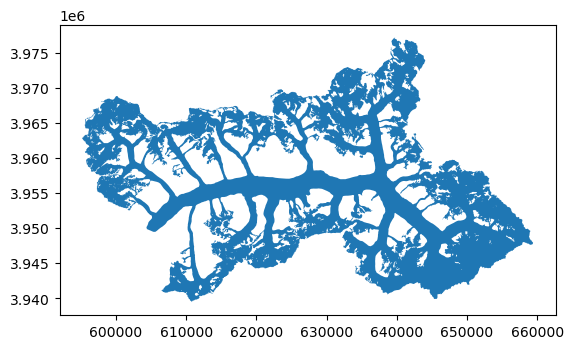

In [11]:
glacier.outline_prj.plot()

The `glacier_point` object also has the RGI ID and name inherited from the map widget but additionally contains ITS_LIVE image pair velocity time series data for the selected point as well as a 3x3 pixel cube surrounding the point. 

In [12]:
glacier_point.cube_around_point

<xarray.Dataset>
Dimensions:                (time_numeric: 9226, x: 3, y: 3)
Coordinates:
    mid_date               (time_numeric) datetime64[ns] 1989-11-25T04:53:12....
  * x                      (x) float64 6.238e+05 6.239e+05 6.241e+05
  * y                      (y) float64 3.956e+06 3.956e+06 3.955e+06
    img_separation         (time_numeric) float64 16.0 112.0 96.0 ... 15.0 5.0
  * time_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
    obs_id                 (time_numeric) int64 2 3 4 5 ... 10404 10405 10406
    mapping                int64 0
Data variables:
    v                      (time_numeric, y, x) float32 nan 99.0 ... 91.0 91.0
    vy                     (time_numeric, y, x) float32 nan -86.0 ... 0.0 0.0
    vx                     (time_numeric, y, x) float32 nan 51.0 ... -91.0 -91.0
    v_error                (time_numeric, y, x) float32 nan 112.0 ... 80.0 80.0
    satellite_img1         (time_numeric) <U2 '5' '5' '5' '5' ... '1A' '2B' '2B'
    satellite_img2         (time_numeric) <U2 '5' '5' '5' '5' ... '1A' '2A' '2A'
    acquisition_date_img1  (time_numeric) datetime64[ns] 1989-11-17T04:53:20....
    acquisition_date_img2  (time_numeric) datetime64[ns] 1989-12-03T04:53:02....
    img1_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
    img2_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 21:40:31
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The `glacier_centerline` object contains the same RGIID and name information as the first two objects. In addition, it contains OGGM centerline data that are stored as geopandas GeodataFrames.

In [13]:
glacier_centerline.main_centerline

,RGIID,SEGMENT_ID,LE_SEGMENT,MAIN,geometry
9603,RGI60-14.06794,28,64947.0,1,"LINESTRING (659310.149 3947895.764, 659110.110..."


Each of these objects are meant to act as cotainers to intuitively and efficiently store different types of data as you process and continue to work with ITS_LIVE data. 

The previous steps demonstrated the data access and organization functionality of ITS_LIVE_TOOl. The subsequent sections of this notebook will demonstrate different processing methodologies for working with this dataset. 

#### If you've selected multiple glaciers, follow these examples:

In [ ]:
#glacier0, glacier1 = obj_setup.create_multiple_glacier_objs(data_map)[0], obj_setup.create_multiple_glacier_objs(data_map)[1]

In [ ]:
# PLEASE DON'T UNCOMMENT, WE ARE WORKING ON THIS

#glacier_point_ls = obj_setup.create_multiple_glacier_point_objs(data_map)
#glacier_pt0, glacier_pt1 = glacier_point_ls[0], glacier_point_ls[1]

## Manual/programmatic data access

#create `Glacier`, `Glacier_Point`, `Glacier_Centerline` objects

Create `Glacier`, `Glacier_Point`, `Glacier_Centerline` objects without using widget. Specify point coordinates (`list`), RGIID (`str`) and utm zone* (`str):

*This is a temporary patch, soon won't have to specify utm zone to create object. 

In [19]:
point = [76.36013929649597, 35.73912785079385]
rgiid = 'RGI60-14.06794'
utm = 'EPSG:32643'

In [23]:
glacier = programmatic_access.create_glacier_obj('name',rgiid, utm)

In [24]:
glacier.name

'name'

In [25]:
glacier.rgi_id

'RGI60-14.06794'

<Axes: >

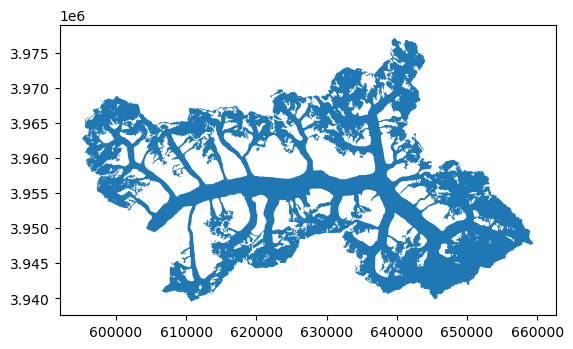

In [26]:
glacier.outline_prj.plot()

In [27]:
glacier_pt = programmatic_access.create_glacier_point_obj(point, 'label', rgiid)

original xy [76.36013929649597, 35.73912785079385] 4326 maps to datacube (622992.2829075075, 3955867.335135076) EPSG:32643
subset and load at   8.35 seconds


In [28]:
glacier_centerline = programmatic_access.create_glacier_centerline_obj('label', rgiid)

In [29]:
glacier_centerline.centerlines

,RGIID,SEGMENT_ID,LE_SEGMENT,MAIN,geometry
9592,RGI60-14.06794,21,12574.0,0,"LINESTRING (635953.734 3972169.938, 635753.709..."
9593,RGI60-14.06794,20,10174.0,0,"LINESTRING (646147.490 3958911.616, 646347.521..."
9594,RGI60-14.06794,22,13140.0,0,"LINESTRING (632711.713 3947115.351, 632708.854..."
9595,RGI60-14.06794,18,15368.0,0,"LINESTRING (617218.051 3967299.394, 617220.923..."
9596,RGI60-14.06794,19,18443.0,0,"LINESTRING (606389.782 3941137.762, 606589.789..."
9597,RGI60-14.06794,17,14671.0,0,"LINESTRING (627001.605 3968640.236, 626804.459..."
9598,RGI60-14.06794,5,4960.0,0,"LINESTRING (656243.754 3952453.728, 656043.716..."
9599,RGI60-14.06794,24,15631.0,0,"LINESTRING (603426.064 3966501.228, 603428.936..."
9600,RGI60-14.06794,25,21611.0,0,"LINESTRING (599991.544 3968852.443, 599994.416..."
9601,RGI60-14.06794,26,9574.0,0,"LINESTRING (627091.103 3948435.425, 627088.242..."


## Data Organization: `Glacier`, `Glacier_Centerline`, `Glacier_Point` object classes

### `Glacier_Point`

This object inherits name and RGIID attributes from the `Glacier` object described aboev (or you can input them manually). It takes the coordinate information specified in the widget and list of variables of interest and returns an object containing ITS_LIVE image pair time series datasets for the specified point anda 3x3 pixel cube surrounding the specified point. Check out the docs for a description of all of the attributes and methods associated with this object. 

In [30]:
glacier_pt.point_gdf

,x,y,geometry
0,76.360139,35.739128,POINT (76.36014 35.73913)


In [31]:
glacier_pt.cube_around_point

<xarray.Dataset>
Dimensions:                (time_numeric: 9299, x: 3, y: 3)
Coordinates:
    mid_date               (time_numeric) datetime64[ns] 1989-11-09T04:53:39....
  * x                      (x) float64 6.229e+05 6.23e+05 6.231e+05
  * y                      (y) float64 3.956e+06 3.956e+06 3.956e+06
    img_separation         (time_numeric) float64 16.0 16.0 112.0 ... 15.0 5.0
  * time_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
    obs_id                 (time_numeric) int64 0 2 3 4 ... 10742 10743 10744
    mapping                int64 0
Data variables:
    v                      (time_numeric, y, x) float32 nan nan ... 46.0 46.0
    vy                     (time_numeric, y, x) float32 nan nan ... 0.0 0.0
    vx                     (time_numeric, y, x) float32 nan nan ... -46.0 -46.0
    v_error                (time_numeric, y, x) float32 nan nan ... 80.0 80.0
    satellite_img1         (time_numeric) <U2 '5' '5' '5' '5' ... '1A' '2B' '2B'
    satellite_img2         (time_numeric) <U2 '5' '5' '5' '5' ... '1A' '2A' '2A'
    acquisition_date_img1  (time_numeric) datetime64[ns] 1989-11-01T04:53:56....
    acquisition_date_img2  (time_numeric) datetime64[ns] 1989-11-17T04:53:20....
    img1_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
    img2_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 21:40:31
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

### `Glacier_Centerline`

Similarly to the `Glacier_Point` object, a `Glacier_Centerline` object inherits some basic information from a `Glacier` object, but this can also be specified manually if you don't want to create a `Glacier` method beforehand. A `Glacier_Centerline` object has attributes called `centerlines` and `main_centerline`. These are both `Geopandas.GeoDataframe` objects containing OGGM flowline data associated with this glacier. They also contain ITS_LIVE image pair velocity time series clipped to the centerline (**still being implemented**).

In [32]:
glacier_centerline = programmatic_access.create_glacier_centerline_obj('Jorge Montt', 'RGI60-17.06074')

In [33]:
glacier_centerline

Each of these objects are meant to act as cotainers to intuitively and efficiently store different types of data as you process and continue to work with ITS_LIVE data. 

The previous steps demonstrated the data access and organization functionality of ITS_LIVE_TOOl. The subsequent sections of this notebook will demonstrate different processing methodologies for working with this dataset. 

# Section 2: Data Processing

## Filtering + Inspection 

Examples of situations where outlier detection may be necessary. We present 3 methods for outlier detection. 

```{note}
add images of figures from notebook here ? 
```


# Section 3: Datacube Inversion

#### *To dive into the theory of the inversion, check-out the '06_inversion.ipynb' notebook*
<br>

#### **Problem:**

*Find a smooth regularly spaced timeseries of velocities given a set of average measurements of possibly overlapping and variable length time intervals*

<br>


#### **Inversion applied to ITS_LIVE:**

ITS_LIVE is a great dataset that achieves high-density measurements globally, on a long timescale, using the same sensors and method.
However it suffers from one main problem: **mid_dates** (timestamps), its attribution of a timestamp for a measurement. For example, if ITS_LIVE uses two images a month apart, it really measures the average velocity for this whole month. Instead, ITS_LIVE attributes to the velocity a timestamp in the middle of the month. 

The inversion computes all the timestamps and the satellite-pairs length, and calculates a solution depending on all the available values.

<br>



### **Input your parameters below**

*Useful information:*

- GPU generally runs the inversion faster, but might be slower when using the spatial regularization.
- High lambda encouraged for non-surging glacier
- spatial_shape 'cross' is hard-coded because 'ring' would take a lot of RAM and the code would be much more complicated.
- spatial_regularization: False if you want a faster computation, slightly less accurate.

In [ ]:
# In case you didn't run the cell that grabs the urls
coords, gpdf, urls = obj_setup.return_clicked_info(data_map)

# In case you haven't created the centerline
glacier_centerline = obj_setup.create_glacier_centerline_from_click(data_map, 0)

###### INPUT YOUR PARAMETERS #######

name_cube = 'Weird' # Name of the dataset

mission = None # 'None' if you want all the data, 'S1' for Sentinel-1 only, 'L' for Landsat only, etc.. .

lamb = 5 # Smoothing coefficient: the higher the value, the more the inversion favors a smooth output. BAD for surging glaciers, GOOD for non-surging glaciers

derivative = 2 # Derivative degree for the inversion. Doesn't change much unless you have a specific reason to choose 1 or 2 (1st or 2nd derivative)

day_interval = 60 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.

sdate = '2019-01-01' # Start date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

edate = None # End date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

GPU = True # True if you want to use GPU, False if you want to use CPU

spatial_regularization = False # True if you want to use spatial regularization, False if you only want to use temporal regularization

if spatial_regularization:
    derivative = 2 # It is better to do a central difference scheme than forward difference in this case
    spatial_shape = 'cross' # 'ring' has not been implemented yet, and tests show a huge in increase in computation time
    nb_pts_tot = 5
else:
    nb_pts_tot = 1
    spatial_shape = None

**Create dictionnaries to hold variables for each datacube**

Each datacube has multiple variables associated with it. We gather all these variables in dictionnaries such as 1 datacube = 1 dictionnary.
We then gather all the dictionnaries into one for easier organization.


In [ ]:
X_tot, Y_tot, X_valid, Y_valid, data_dict, urls = invert.create_data_dict(urls, mission, lamb, derivative, day_interval, data_map)

## Datacubes Extent and Point Validity

Designed to grab the extents of the datacubes, and determines which pixel belongs to the GOI (Glacier Of Interest). This way we do not lose time inverting for empty pixels.

In [ ]:
for url in tqdm(range(len(urls))):
    X_tot, Y_tot, X_valid, Y_valid = invert.get_extents(urls[url], X_tot, Y_tot, X_valid, Y_valid, mission, lamb, derivative, day_interval, data_map, data_dict)

### Map the valid indices in a new array

This new array spans all the datacubes. We take the footprint of the GOI, insert-it in an array, and map in this array which pixel is on-glacier.
It allows to run the inversion for glacier-points only, accross all the datacubes, and store the inversion output in an array that represents the glacier's shape.

In [ ]:
space_interval, min_date, max_date, template, P, neighbor_idx, x_indices_centerline, y_indices_centerline, X_arr, X_MIN, X_MAX, Y_arr, Y_MIN, Y_MAX, x_matches, y_matches = invert.cubes_intersection(X_tot, Y_tot, X_valid, Y_valid, data_dict, urls, spatial_regularization, mission, lamb, derivative, day_interval, sdate, edate, nb_pts_tot, glacier_centerline)

## Design Matrices

This function creates 1 design matrix per cube. Knowing that each cube has different time stamps (different image pairs), but the possible dates for the image pairs are the same for every pixel of the datacube, we can pre-compute 1 design-matrix for each cube. We will simply mask-out the rows that represent time steps for which our point being inverted does not have any value.

In [ ]:
reg_mat_space, reg_mat_time, dates_nonum, dates, data_dict = invert.design_matrices(urls, min_date, max_date, mission, lamb, derivative, day_interval, space_interval, sdate, edate, data_dict)

#### Design Matrix components

Build the last bricks of the design matrix depending on how many points we use in the regularization & initialize host arrays for the inversion outputs



In [ ]:
vxInv, vyInv, len_pt_inverted, SRT, SRS, space_reg_mat, time_reg_mat =  invert.extend_Matrices(reg_mat_time, nb_pts_tot, reg_mat_space, spatial_regularization, dates, template)

### Function to loop through every valid on-glacier pixel and save the dataset

The following function calls the point's timeseries from ITS_LIVE, assembles the design matrix, and calls the inversion function. Once it is done, it stores the inversion output in the host matrices (vx & vy). It saves a copy of the matrices as a netcdf object every 10k iterations, and creates a text file printing how many iterations have been computed, every 100 iterations.

In [ ]:
# Determine the GPU in your system if you have one
if GPU:     
    import torch
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = None

# Run the inversions for vx and vy and populate vxInv, vyInv
for i in tqdm(range(len(y_matches))):

    vxInv, vyInv = invert.looper(i, name_cube, vxInv, vyInv, GPU, spatial_regularization, nb_pts_tot, time_reg_mat, space_reg_mat, len_pt_inverted, data_dict, urls, P, neighbor_idx, x_matches, y_matches, X_arr, X_MIN, X_MAX, Y_arr, Y_MIN, Y_MAX, device, dates_nonum, x_indices_centerline, y_indices_centerline, SRT, SRS)
    
invert.save_dataset(name_cube, vxInv, vyInv, dates_nonum, X_arr, Y_arr, X_MIN, X_MAX, Y_MIN, Y_MAX, x_indices_centerline, y_indices_centerline, data_dict, urls)